# DeepDream

We'll describe an implementation of DeepDream.

In [1]:
import sys
sys.path.insert(0, "../../../")

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

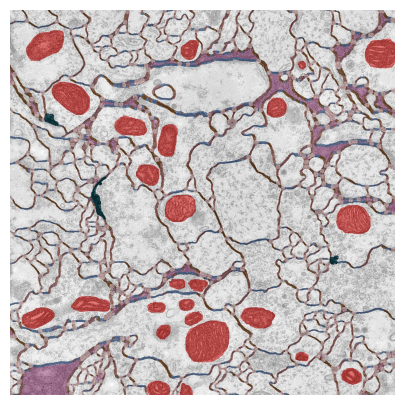

In [2]:
from PIL import Image
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1288336/preview.jpg'
im = Image.open(urlopen(url))

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 5))
plt.imshow(im)
plt.axis('off')
plt.show()

We'll download a pretrained model (VGG16) and freeze the layers

In [3]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad_(False)

print(model)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
def deepdream(im, test_layer, num_iterations=500, learning_rate=1.e0):

    import torch
    from deepdream import fwd_hook, preprocess, deprocess

    image = preprocess(im)
    model.eval()
    for t in range(num_iterations):
 
        with fwd_hook(test_layer) as fh:
            out = model(image)
        score = fh.stored.mean()
        score.backward()
   
        image.data += (learning_rate*image.grad.data/torch.linalg.norm(image.grad.data))
        image.grad.data.zero_()

        image.data.clamp_(min=-3, max=3)
    return deprocess(image.data.clone().detach()), t

In [14]:
test_layer = model.features[4]
im_out, num_iterations  =  deepdream(im, test_layer, num_iterations=100, learning_rate=5.e0)


We'll display the results in comparison with the original image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 't' is not defined

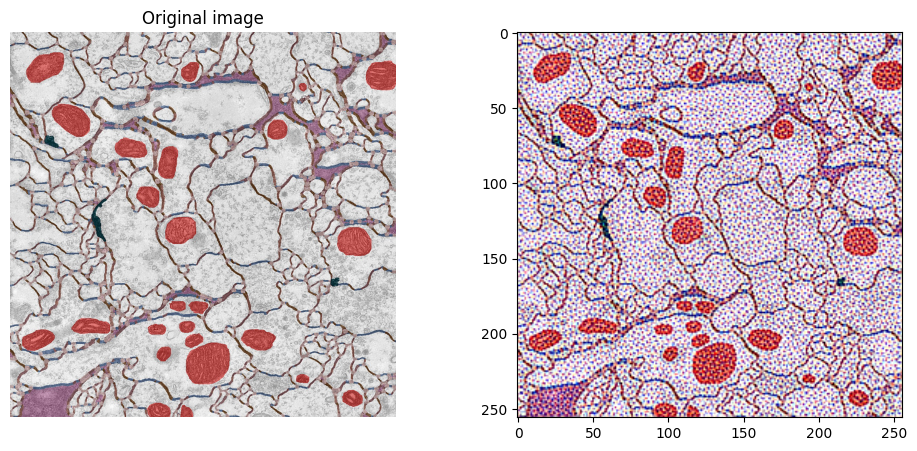

In [ ]:
plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_out, interpolation='bilinear')
plt.title(f"Iteration {t+1} / {num_iterations}") 
plt.axis('off')
plt.show()


Octaves

In [ ]:
octave_scale = 1.3
for n in range(-2,3):
    